# **Modelado**

En este notebook hacemos todo el proceso de fine-tuning de los 3 modelos diferente y evaluamos su performance.

# 0. Librerías 

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report
import joblib

# Seteamos uso de gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")


c:\Users\juan_\anaconda3\envs\sent-nlp-v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


# 1. Datos preprocesados

In [2]:
df_train = pd.read_csv('../data/processed/train_encoded.csv')
df_test = pd.read_csv('../data/processed/test_encoded.csv')

In [3]:
df_train.head()

,OriginalTweet,Sentiment
0,and and,2
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,me ready to go at supermarket during the outbr...,0


In [4]:
df_test.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermark...,0
1,when i couldnt find hand sanitizer at fred mey...,3
2,find out how you can protect yourself and love...,4
3,buying hits city as anxious shoppers stock up ...,1
4,one week everyone buying baby milk powder the ...,2


# 2. Tokenization

In [5]:
# Inicializamos el tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Definimos función para tokenizar data. Seteamos max_length=128 de acuerdo a lo analizado en el EDA.
def tokenize_data(data):
    tokenized = tokenizer(data.astype(str).tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
    
    return tokenized

In [6]:
# Tokenizamos los tweets
train_tokenized = tokenize_data(df_train['OriginalTweet'])
test_tokenized = tokenize_data(df_test['OriginalTweet'])

In [7]:
train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

# 3. TensorDataset

In [8]:
# Convertimos la etiqueta, Sentiment, en tensores
labels_train = torch.tensor(df_train['Sentiment'])
labels_test = torch.tensor(df_test['Sentiment'])

In [9]:
labels_train

tensor([2, 3, 3,  ..., 3, 2, 1])

In [10]:
# Creamos el TensorDataset, objeto necesario para trabajar en pytorch
train_dataset = TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'], labels_train)
test_dataset = TensorDataset(test_tokenized['input_ids'], test_tokenized['attention_mask'], labels_test)

In [11]:
train_dataset

# 4. DataLoaders

In [12]:
# Definimos los dataloaders para entregar los TensorDataset a pytorch por batches

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [13]:
train_dataloader

# 5. Función de Pérdida

In [14]:
# Calculamos los pesos para ponderar la función de pérdida para mitigar el desbalance de clases en el dataset original

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.numpy()), y=labels_train.numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [15]:
class_weights

array([1.50180624, 0.83002924, 1.0672112 , 0.72066188, 1.24266304])

In [16]:
class_weights_tensor

tensor([1.5018, 0.8300, 1.0672, 0.7207, 1.2427], device='cuda:0')

In [17]:
# Definimos la función de pérdida
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [18]:
loss_fn

CrossEntropyLoss()

# 6. Entrenamiento de BERT

In [19]:
# Definimos el modelo

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, return_dict=True)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Definimos optimizer inicial
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=1e-7)


In [21]:
# Entrenamos el modelo

from tqdm import tqdm
import torch
import numpy as np

# 1. Configuraciones generales
epochs = 3


# definimos scheduler
scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=epochs * len(train_dataloader)
)

# 3. Entrenamiento
for epoch in range(epochs):
    print(f"🔁 Epoch {epoch + 1}/{epochs}")
    
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Acumulación de métricas
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = train_loss / len(train_dataloader)
    acc = correct / total
    print(f"📉 Train Loss: {avg_loss:.4f} | 🎯 Train Accuracy: {acc:.4f}")

    # 4. Validación al final del epoch
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(test_dataloader)
    val_acc = correct / total
    print(f"✅ Val Loss: {avg_val_loss:.4f} | 🎯 Val Accuracy: {val_acc:.4f}")


🔁 Epoch 1/3


100%|██████████| 2573/2573 [38:12<00:00,  1.12it/s]  


📉 Train Loss: 1.1133 | 🎯 Train Accuracy: 0.4920
✅ Val Loss: 0.8505 | 🎯 Val Accuracy: 0.6290
🔁 Epoch 2/3


100%|██████████| 2573/2573 [28:03<00:00,  1.53it/s]   


📉 Train Loss: 0.7496 | 🎯 Train Accuracy: 0.6800
✅ Val Loss: 0.7086 | 🎯 Val Accuracy: 0.6977
🔁 Epoch 3/3


100%|██████████| 2573/2573 [44:40<00:00,  1.04s/it]  


📉 Train Loss: 0.6522 | 🎯 Train Accuracy: 0.7296
✅ Val Loss: 0.6803 | 🎯 Val Accuracy: 0.7064


# 7. Evaluación de BERT

In [ ]:


encoder = joblib.load('../models/ordinal_encoder.pkl')

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=encoder.categories_[0]))


                    precision    recall  f1-score   support

Extremely Negative       0.69      0.89      0.78       592
          Negative       0.69      0.64      0.66      1041
           Neutral       0.77      0.78      0.77       619
          Positive       0.70      0.54      0.61       947
Extremely Positive       0.71      0.83      0.76       599

          accuracy                           0.71      3798
         macro avg       0.71      0.74      0.72      3798
      weighted avg       0.71      0.71      0.70      3798



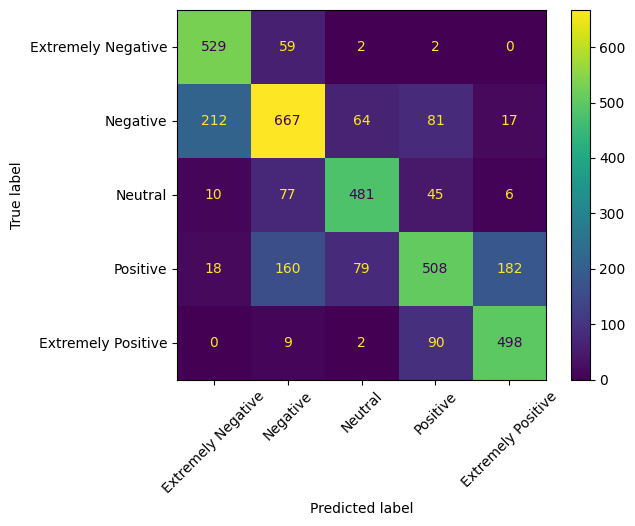

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
disp.plot(xticks_rotation=45)


# 8. Guardamos el modelo 

In [32]:
# Guardamos el estado actual del modelo y el tokenizer

model.save_pretrained("../models/bert_sentiment_analysis_model")
tokenizer.save_pretrained("../models/bert_sentiment_analysis_model")

('../models/bert_sentiment_analysis_model\\tokenizer_config.json',
 '../models/bert_sentiment_analysis_model\\special_tokens_map.json',
 '../models/bert_sentiment_analysis_model\\vocab.txt',
 '../models/bert_sentiment_analysis_model\\added_tokens.json',
 '../models/bert_sentiment_analysis_model\\tokenizer.json')

# 9. Cargamos el modelo y lo probamos

In [33]:
def load_sentiment_model(model_path: str, encoder_path: str, device=None):
    """
    Carga el modelo de sentimiento, tokenizer y encoder desde disco.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Modelo con la arquitectura base
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Encoder de etiquetas
    encoder = joblib.load(encoder_path)

    return model, tokenizer, encoder


In [34]:
model, tokenizer, encoder = load_sentiment_model('../models/bert_sentiment_analysis_model','../models/ordinal_encoder.pkl' )

In [35]:
def predict_tweet(text, model, tokenizer, device):
    # Tokenizar el texto
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    # Enviar al mismo dispositivo del modelo
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Desactivamos gradientes porque es inferencia
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.squeeze().cpu().numpy()


In [43]:
import random

# Seleccionar un tweet al azar
tweet = random.choice(df_test['OriginalTweet'].dropna().tolist())
tweet

'airlines plane ticket prices are dropping because of the coronavirusâ my cheap ass making bookings coz if i die i better die in bali'

In [44]:
pred_class, probs = predict_tweet(tweet, model, tokenizer, device)
pred_class = encoder.inverse_transform(np.array(pred_class).reshape(-1, 1)).flatten()
print(f"Predicción: Clase {pred_class}")
print(f"Probabilidades: {probs}")


Predicción: Clase ['Extremely Negative']
Probabilidades: [0.9468299  0.04069261 0.00359496 0.00503625 0.00384631]


In [46]:
df_test.loc[df_test['OriginalTweet']==tweet]

,OriginalTweet,Sentiment
701,airlines plane ticket prices are dropping beca...,0
